# Import Libraries

In [1]:
import pickle
import json
import matplotlib.pyplot as plt
import pymongo
from bson.son import SON
from pymongo import MongoClient
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline

# Import Some Data for MVP Models

In [2]:
#client = MongoClient(port=27017)
#db = client.tweet_on_vegan
#popular_tweets = db.streaming_tweets
#texts = popular_tweets.find({}, {'_id':1,"id":1,"text":1,'is_retweet':1}).skip(116500).limit(100)
#for text in texts:
    #pass
    #print(text)

In [3]:
client = MongoClient(port=27017)
db = client.tweet_on_vegan
popular_tweets = db.streaming_tweets
texts = popular_tweets.find({'lang':'en'}, {'_id':0,"text":1}).limit(115000)
tweets = [text['text'] for text in texts]

In [4]:
import pandas as pd
mvp_tweets = pd.DataFrame(tweets, columns=['tweets'])
mvp_tweets.sample(5)

,tweets
24748,yes i'm vegan. yes i eat meat. we exist.
79459,Don't forget to go to @Food_CU today from 12pm...
71884,Your protein guide. #vegan #protein https://t....
89575,Looking forward to enjoying this @DearCocoChoc...
102665,@_Alfista I think people might notice when I'm...


# Clean Data

* Remove urls
* Remove user names
* Remove line breaks
* Group tweets and count retweets

In [5]:
import re
from string import punctuation

def clean_tweet(x):
    x = x.strip()
    x = re.sub(r'http\S+', '', x, flags=re.MULTILINE)
    x = re.sub(r'RT\s@\S+', '', x, flags=re.MULTILINE)
    x = re.sub(r'@\S+', '', x, flags=re.MULTILINE)
    x = re.sub(r'\n', '', x, flags=re.MULTILINE)
    return (''.join(c for c in x if c not in punctuation+"'")).strip()

mvp_tweets.tweets = mvp_tweets.tweets.apply(clean_tweet)

mvp_tweets = (pd.DataFrame(mvp_tweets.tweets.value_counts())
              .reset_index()
              .rename(columns={'tweets':'retweets', 'index': 'text'}))
mvp_tweets.sample(5)

,text,retweets
35805,This is great news amp makes me so happy😊 Sout...,1
22160,My bff is vegan if u still need people 😊 love ...,1
6595,Looooool Serena 😂😂😂😂 good night,2
8,This is what happens when you go vegan,353
12359,no one’s forcing you to be vegan susan,1


# *Come back for sentimental analysis (when I find a better libraries)*

In [6]:
# Import
#from textblob import TextBlob

# Create "blobs"
#foo['textblob'] = foo.text.apply(TextBlob)
#foo['sentiment'] = foo.text.apply(lambda x: TextBlob(x).sentiment)

#foo.sample(5)

# MVP Model 1
* TF-IDF (sklearn)
* LSA (gensim)

In [7]:
#import numpy as np
#from nltk.tokenize import word_tokenize, wordpunct_tokenize, WhitespaceTokenizer
#from nltk.chunk import ne_chunk
#from nltk.tag import pos_tag

# Text with some entities
#sample_tweet = np.array(foo.text)
#for t in sample_tweet[:5]:
#    tokens = pos_tag(word_tokenize(t))
#    entities = ne_chunk(tokens)

#foo.text.apply(lambda x: pos_tag(word_tokenize(x)))



## TF-IDF (sklearn)

In [6]:
from sklearn.feature_extraction import text

my_stop_words = text.ENGLISH_STOP_WORDS.union(["amp", "vegan"])

In [7]:
# Import
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.lancaster import LancasterStemmer

# This uses WordNet (huge lexical database of English words)
stemmer = LancasterStemmer()
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

# Create a vectorizer object to generate term document counts
# Note all the parameters we can use, let's play!
tfidf = TfidfVectorizer(token_pattern='[a-z][a-z]+',
                        stop_words = my_stop_words, 
                        min_df=50, max_df=0.8, ngram_range=(1,1))
                        #analyzer=stemmed_words)
# Get the vectors
sample_tweet_train = tfidf.fit_transform(mvp_tweets.text)
# Store them in a Pandas DataFrame
#sample_tweet_train_df = pd.DataFrame(sample_tweet_train.todense(), 
                           #columns=[tfidf.get_feature_names()])
#sample_tweet_train_df.head()

In [8]:
len(tfidf.get_feature_names())

1513

## LSA (gensim)

In [9]:
# Import
from gensim import corpora, models, similarities, matutils

In [10]:

# Convert sparse matrix of counts to a gensim corpus
# Need to transpose it for gensim which wants 
# terms by docs instead of docs by terms
tfidf_corpus = matutils.Sparse2Corpus(sample_tweet_train.transpose())

# Row indices
id2word = dict((v, k) for k, v in tfidf.vocabulary_.items())

# This is a hack for Python 3!
id2word = corpora.Dictionary.from_corpus(tfidf_corpus, 
                                         id2word=id2word)

In [11]:
# Build an LSI space from the input TFIDF matrix, mapping of row id to word, and num_topics
# num_topics is the number of dimensions to reduce to after the SVD
# Analagous to "fit" in sklearn, it primes an LSI space
lsi = models.LsiModel(tfidf_corpus, id2word=id2word, num_topics=300)

In [12]:
# Retrieve vectors for the original tfidf corpus in the LSI space ("transform" in sklearn)
lsi_corpus = lsi[tfidf_corpus]

# Dump the resulting document vectors into a list so we can take a look
doc_vecs = [doc for doc in lsi_corpus]

**Two most retweeted tweets have lots variation. Taking out these variation to see if a better insight is observed**

In [13]:
# Create an index transformer that calculates similarity based on 
# our space
index = similarities.MatrixSimilarity(doc_vecs, 
                                      num_features=300)

In [14]:
# Return the sorted list of cosine similarities to the first document
sims = sorted(enumerate(index[doc_vecs[67]]), key=lambda item: -item[1])

In [15]:
#similar_tweet = {}
#similar_tweet[0] = []

In [16]:
for tweet, similarity in sims:
    if similarity >= 0.5:
        #pass
        print(mvp_tweets.iloc[tweet, 0])
        #similar_tweet[1].append(tweet)

people automatically assume that I’m really healthy because I’m a vegan but in reality i just had half of a bag of takis for dinner
people automatically assume that I’m really healthy because I’m a vegan but in reality i just had half of a bag of takis f…
VEGAN DINNER PARTY FOR 20 3 courses 4 people  via
How To Really Get People To Go Vegan
Can you really be a healthy vegan
People really put “vegan” in their bio Is it ever that serious
Day 4 of detox in the bag with vegan stuffed poblanos for dinner and a lime and ginger mocktail 🍸
people really force their dogs amp cats to be vegan
Habits of people who have achieved worklife balance  … vegan healthy fit
agreed and also I really should just go the full vegan at this point
Love my vegan stir fry yesterday evening vegan beautifulfood healthy healthyrecipe dinner
Never trust those mom bloggers that claim their kids loved the healthy dinner they madeTheyve neglected to mention that their kids are paleovegan activistsmomlife
Just found out 

In [ ]:
#mvp_tweets = mvp_tweets.drop(similar_tweet[0][1:], axis=0)
#mvp_tweets = mvp_tweets.drop(similar_tweet[1][1:], axis=0)

## TF-IDF v2 (sklearn)

In [ ]:
# Import
from sklearn.feature_extraction.text import TfidfVectorizer
# Create a vectorizer object to generate term document counts
# Note all the parameters we can use, let's play!
tfidf = TfidfVectorizer(token_pattern='[a-z][a-z]+',
                                  stop_words = 'english', min_df=5, ngram_range=(1,2))
                                  #analyzer=stemmed_words)
# Get the vectors
sample_tweet_train = tfidf.fit_transform(mvp_tweets.text)
# Store them in a Pandas DataFrame
#sample_tweet_train_df = pd.DataFrame(sample_tweet_train.todense(), 
                           #columns=[tfidf.get_feature_names()])
#sample_tweet_train_df.head()

In [ ]:
sample_tweet_train

## LSA v2 (gensim)

In [ ]:
# Import
from gensim import corpora, models, similarities, matutils

In [ ]:
# Convert sparse matrix of counts to a gensim corpus
# Need to transpose it for gensim which wants 
# terms by docs instead of docs by terms
tfidf_corpus = matutils.Sparse2Corpus(sample_tweet_train.transpose())

# Row indices
id2word = dict((v, k) for k, v in tfidf.vocabulary_.items())

# This is a hack for Python 3!
id2word = corpora.Dictionary.from_corpus(tfidf_corpus, 
                                         id2word=id2word)

In [ ]:
# Build an LSI space from the input TFIDF matrix, mapping of row id to word, and num_topics
# num_topics is the number of dimensions to reduce to after the SVD
# Analagous to "fit" in sklearn, it primes an LSI space
lsi = models.LsiModel(tfidf_corpus, id2word=id2word, num_topics=500)

In [ ]:
# Retrieve vectors for the original tfidf corpus in the LSI space ("transform" in sklearn)
lsi_corpus = lsi[tfidf_corpus]

# Dump the resulting document vectors into a list so we can take a look
doc_vecs = [doc for doc in lsi_corpus]

In [ ]:
# Create an index transformer that calculates similarity based on 
# our space
index = similarities.MatrixSimilarity(doc_vecs, 
                                      num_features=500)

In [ ]:
# Return the sorted list of cosine similarities to the first document
sims = sorted(enumerate(index[doc_vecs[1]]), key=lambda item: -item[1])

In [ ]:
for tweet, similarity in sims:
    if similarity >= 0.5:
        pass
        #print(mvp_tweets.iloc[tweet, 0])
        #similar_tweet[1].append(tweet)

# KMean

In [17]:
# Convert the gensim-style corpus vecs to a numpy array for sklearn manipulations
ng_lsi = matutils.corpus2dense(lsi_corpus, num_terms=300).transpose()
ng_lsi.shape

(51021, 300)

In [19]:
from sklearn.cluster import KMeans, MiniBatchKMeans

In [25]:
# Create KMeans
kmeans = MiniBatchKMeans(n_clusters=35)

# Cluster
ng_lsi_clusters = kmeans.fit_predict(ng_lsi)

In [26]:
for i, tweet in enumerate(mvp_tweets.text):
    if ng_lsi_clusters[i] == 0:
        print(tweet)

Nashville Hot Chicken Sauce Way Hot NonGMO GlutenFree AllNatural Vegan SugarFree
What will you have for dinner  vegan recipes
TBT  Oooou freestyle fathers savemusic hot16 hiphop rap positivevibes vegan interstellarrmusic 💯✊🏽
IKEA adds plantbased hot dog to menu
Wow Vegan amp Glutenfree Hot Cross Buns with  too👏👏👏💚💚🌱🌱
IKEA Announces a New Vegan Hot Dog and We’re So Here for It  via
Pizza but it turns out to be veganAlmost as disappointing as meeting a hot girl but she turns out to be vegan
Hot cocoa season is in full swing  😄☕ Try these tasty vegan hot cocoa mixes
Salted caramel vegan Easter hot chocolate spoonStir into a mug of hot coconut or almond milk for a delicious vegan hot chocolate 🍫☕easterdunkstirenjoyartispoonz
Dinner Made some mutha fukkin stir frystirfry veggies vegan veganfoodshare wok dinner…
IKEA Announces a New Vegan Hot Dog and We’re So Here for It
Perfect for a spicy 🌶 creamy vegan dinner aloo gobi  my primrose hill kitchenvegan dinner
i step into the vegan chati post

(array([  211.,  1815.,    59.,   569.,    69.,   506., 39869.,    98.,
         1921.,   298.,   197.,   268.,  1253.,   984.,   561.,   214.,
         1225.,   229.,   675.]),
 array([ 0.        ,  1.78947368,  3.57894737,  5.36842105,  7.15789474,
         8.94736842, 10.73684211, 12.52631579, 14.31578947, 16.10526316,
        17.89473684, 19.68421053, 21.47368421, 23.26315789, 25.05263158,
        26.84210526, 28.63157895, 30.42105263, 32.21052632, 34.        ]),
 <a list of 19 Patch objects>)

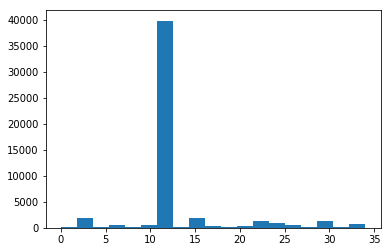

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(ng_lsi_clusters, bins=19)

In [22]:
ng_lsi.shape

(51021, 300)

In [23]:
from sklearn.metrics import silhouette_score

SSEs = []
Sil_coefs = []
for k in range(20,50):
    #km = KMeans(n_clusters=k, random_state=1)
    km = MiniBatchKMeans(n_clusters=k, random_state=54)
    km.fit(ng_lsi)
    labels = km.labels_
    Sil_coefs.append(silhouette_score(ng_lsi, labels, metric='euclidean'))
    SSEs.append(km.inertia_) 
    
   # print(Sil_coefs)
   # print(labels)

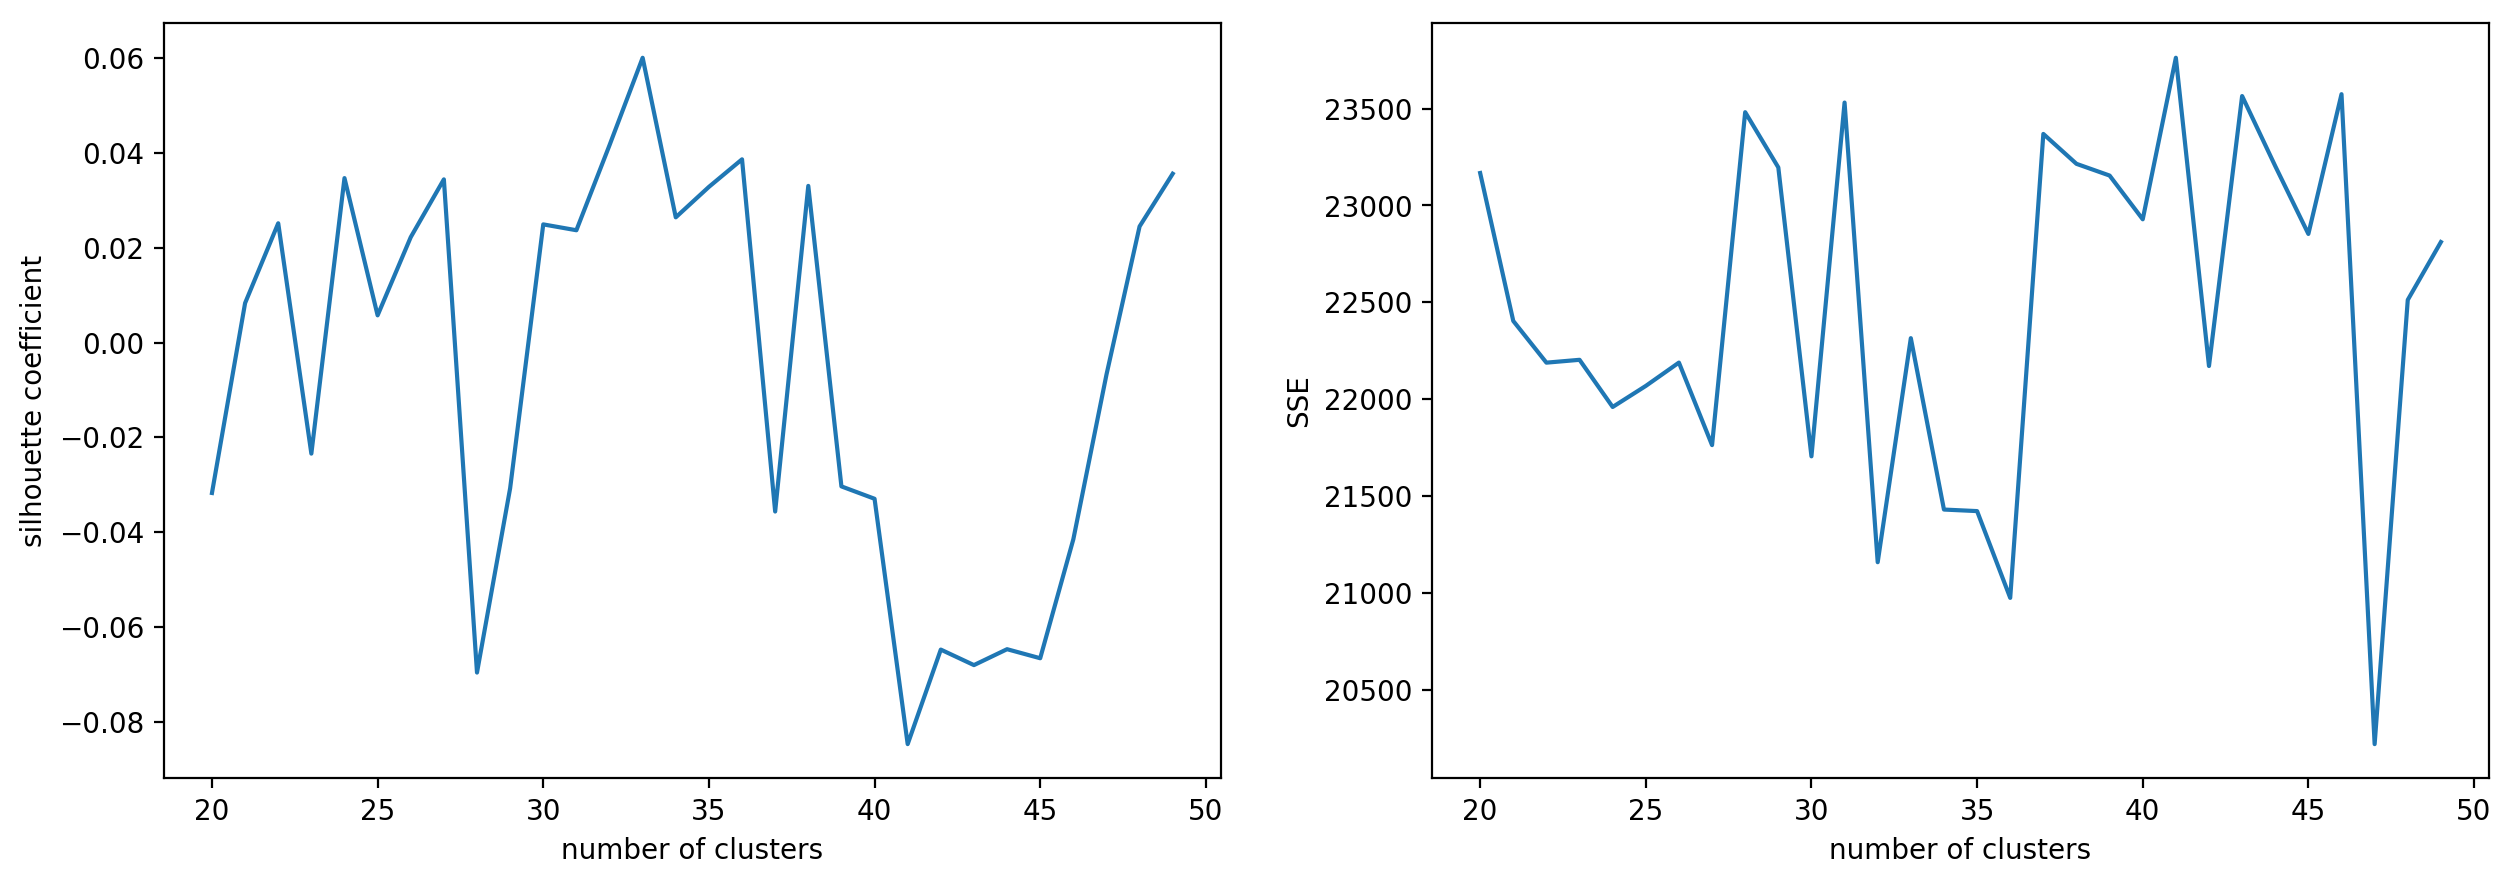

In [24]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True, dpi=200)
k_clusters = range(20,50)
ax1.plot(k_clusters, Sil_coefs)
ax1.set_xlabel('number of clusters')
ax1.set_ylabel('silhouette coefficient')

# plot here on ax2
ax2.plot(k_clusters, SSEs)
ax2.set_xlabel('number of clusters')
ax2.set_ylabel('SSE');

# LDA

In [29]:
# Import
from nltk.stem.lancaster import LancasterStemmer

# This uses WordNet (huge lexical database of English words)
stemmer = LancasterStemmer()
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

count_vectorizer = CountVectorizer(ngram_range=(1, 2),  
                                  stop_words=my_stop_words, 
                                  token_pattern="\\b[a-z][a-z]+\\b" )
                                  #analyzer=stemmed_words)

# Create a vectorizer object to generate term document counts
# Note all the parameters we can use, let's play!
#cv = CountVectorizer(token_pattern='[a-z][a-z]+',
#                     stop_words = 'english')
# Get the vectors
count_vectorizer.fit(mvp_tweets.text)
counts = count_vectorizer.transform(mvp_tweets.text).transpose()
# Store them in a Pandas DataFrame
#sample_tweet_train_df = pd.DataFrame(sample_tweet_train.todense(), columns=[stem_vectorizer.get_feature_names()])
#ng_train_df.head()

In [30]:
corpus = matutils.Sparse2Corpus(counts)

In [31]:
id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())

In [32]:
lda = models.LdaModel(corpus=corpus, num_topics=5, id2word=id2word, passes=10)

In [34]:
lda.print_topics(num_words=20)


[(0,
  '0.005*"video" + 0.005*"free" + 0.004*"food" + 0.003*"liked" + 0.003*"healthy" + 0.003*"protein" + 0.003*"liked video" + 0.002*"cooking" + 0.002*"health" + 0.002*"thanks" + 0.002*"like" + 0.002*"pizza" + 0.002*"chicken" + 0.002*"latest" + 0.002*"happy" + 0.002*"gluten" + 0.002*"recipe" + 0.002*"daily" + 0.002*"diet" + 0.002*"gluten free"'),
 (1,
  '0.006*"recipe" + 0.006*"recipes" + 0.004*"glutenfree" + 0.004*"delicious" + 0.004*"vegetarian" + 0.004*"chocolate" + 0.003*"cream" + 0.003*"cheese" + 0.003*"plantbased" + 0.003*"easy" + 0.003*"healthy" + 0.003*"make" + 0.003*"food" + 0.003*"rt" + 0.002*"raw" + 0.002*"soup" + 0.002*"healthyfood" + 0.002*"ice" + 0.002*"new" + 0.002*"dinner"'),
 (2,
  '0.009*"like" + 0.008*"just" + 0.008*"im" + 0.007*"eat" + 0.005*"meat" + 0.005*"food" + 0.005*"good" + 0.005*"going" + 0.004*"people" + 0.004*"know" + 0.004*"dont" + 0.003*"love" + 0.003*"want" + 0.003*"really" + 0.003*"make" + 0.003*"eating" + 0.003*"think" + 0.003*"try" + 0.003*"yes" + 0.

# Conclusion

* I don't have anything insightful. I'm going to try using spacy to preprocess tweet then fit the model again.

* *ignore below, WIP*

In [ ]:
import spacy

nlp = spacy.load('en')

In [ ]:
a = nlp(foo.iloc[0,0])

print('token')
for token in a:
    print(token)
print('noun chunks')
for b in a.noun_chunks:
    print(b)

In [ ]:
pos_dict = {}

for tweet in np.array(foo.text):
    doc = nlp(tweet)

    for token in doc:        
        if token.is_alpha & ~token.is_stop:
            pos = token.pos_
            lemma = token.lemma_
            
            if pos not in pos_dict.keys():
                pos_dict[pos] = {}
                pos_dict[pos][lemma] = 1
            elif lemma not in pos_dict[pos].keys():
                pos_dict[pos][lemma] = 1
            else:
                pos_dict[pos][lemma] += 1
                

In [ ]:
pos_dict.keys()

In [ ]:
import operator
sorted_x = sorted(pos_dict['ADJ'].items(), key=operator.itemgetter(1))

In [ ]:
sorted_x[-50:]

In [ ]:
for ent in a.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

In [ ]:
ent_dict = {}

for tweet in np.array(foo.text):
    doc = nlp(tweet)

    for ent in doc.ents:   
        label = ent.label_
        text = ent.text
        if ent.label_ not in ent_dict.keys():
            ent_dict[label] = {}
            ent_dict[label][text] = 1
        elif text not in ent_dict[label].keys():
            ent_dict[label][text] = 1
        else:
            ent_dict[label][text] += 1
                

In [ ]:
ent_dict.keys()

In [ ]:
import operator
sorted_x = sorted(ent_dict['LOC'].items(), key=operator.itemgetter(1))

In [ ]:
sorted_x[-50:]

In [ ]:
for tweet in np.array(foo.text):
    doc = nlp(tweet)

    for noun_chunks in doc.noun_chunks:   
        if noun_chunks not in pos_dict['NOUN'].keys():
            pos_dict['NOUN'][noun_chunks] = 1
        else:
            pos_dict['NOUN'][noun_chunks] = 1

In [ ]:
import operator
sorted_x = sorted(pos_dict['NOUN'].items(), key=operator.itemgetter(1))
sorted_x.reverse()